In [44]:
import phemed as phe
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload
import sys
import warnings
from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import minimize

In [60]:
from tqdm import tqdm_notebook

In [53]:
import bootstrap as boots

In [54]:
reload(phe)
reload(boots)

<module 'bootstrap' from '/Users/davidburstein/Documents/GitHub/PheMED/bootstrap.py'>

### 1. Generate Data

In [25]:
np.random.seed(20)
n_snps = 5000
gold_means = .03*np.ones(n_snps)
diluted_means = .5*gold_means
sample_gold = 1000
sample_diluted = 1000
se_gold = 1/np.sqrt(500)
se_diluted = 1/np.sqrt(10000)

In [ ]:
# TWAS_N*alpha^2 = SC_RNASEQ
#alpha = sqrt(SC_RNASEQ/TWAS_N) = sqrt(1000/20000) = sqrt(1/20)

In [55]:
np.sqrt(1/20)
#alpha = [1, .223]
#alpha = [1,1]

0.22360679774997896

In [26]:
df_results = pd.DataFrame(columns = ['SNP','CHR','POS','BETA_Gold','BETA_Diluted','SE_Gold','SE_Diluted'])

In [27]:
df_results['SNP'] = np.arange(1,n_snps + 1)
df_results['CHR'] = 1
df_results['POS'] = df_results['SNP']
df_results['BETA_Gold'] = np.random.normal(gold_means, se_gold)
df_results['BETA_Diluted'] = np.random.normal(diluted_means, se_diluted)
df_results['SE_Gold'] = se_gold
df_results['SE_Diluted'] = se_diluted

In [28]:
df_results

,SNP,CHR,POS,BETA_Gold,BETA_Diluted,SE_Gold,SE_Diluted
0,1,1,1,0.069529,0.010957,0.044721,0.01
1,2,1,2,0.038759,0.015121,0.044721,0.01
2,3,1,3,0.045990,-0.000488,0.044721,0.01
3,4,1,4,-0.074794,-0.010719,0.044721,0.01
4,5,1,5,-0.018515,0.011009,0.044721,0.01
...,...,...,...,...,...,...,...
4995,4996,1,4996,0.078014,0.004748,0.044721,0.01
4996,4997,1,4997,0.040007,0.025823,0.044721,0.01
4997,4998,1,4998,-0.057730,0.006685,0.044721,0.01
4998,4999,1,4999,-0.003057,0.001067,0.044721,0.01


### 2. Run PheMed

In [29]:
beta_vars = [var for var in df_results.columns if var.startswith('BETA')]
beta_vars

['BETA_Gold', 'BETA_Diluted']

In [30]:
se_vars = [var for var in df_results.columns if var.startswith('SE')]
se_vars

['SE_Gold', 'SE_Diluted']

In [31]:
betas = df_results[beta_vars]
ses = df_results[se_vars]

In [34]:
optimizer = minimize(lambda x: phe.nll_data(betas,ses, x), np.array((1,1)), 
                        options={'maxiter': 300}, method = 'Nelder-Mead')
#code normalizes first entry to be 1
optimizer.x[0] = 1

In [36]:
optimizer

 final_simplex: (array([[1.        , 1.92982354],
       [0.56018589, 1.92982354],
       [0.56013706, 1.92982354]]), array([2449.79496822, 2449.79496822, 2449.79496822]))
           fun: 2449.794968222299
       message: 'Optimization terminated successfully.'
          nfev: 115
           nit: 56
        status: 0
       success: True
             x: array([1.        , 1.92982354])

In [38]:
#negative log likelihood of alpha
phe.nll_data(betas, ses, optimizer.x)

2449.794968222299

In [35]:
optimizer.x

array([1.        , 1.92982354])

In [46]:
plot_results = phe.nll_search2D(betas, ses)
plot_results

,Alpha,NLL
0,0.100000,3451.180461
1,0.109820,3440.359554
2,0.119639,3429.589099
3,0.129459,3418.869390
4,0.139279,3408.200718
...,...,...
495,4.960721,3682.197143
496,4.970541,3687.489877
497,4.980361,3692.779979
498,4.990180,3698.067399


Text(0, 0.5, 'Log Likelihood')

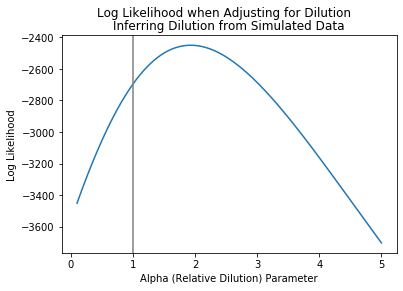

In [47]:
plot_results['LL'] = -1*plot_results['NLL']
sns.lineplot(data = plot_results, x = 'Alpha', y = 'LL')
plt.axvline(x = 1, color = 'grey')
plt.suptitle('Log Likelihood when Adjusting for Dilution')
plt.title('Inferring Dilution from Simulated Data')
plt.xlabel('Alpha (Relative Dilution) Parameter')
plt.ylabel('Log Likelihood')

### 3. Meta-Analysis

In [48]:
df_results['Z'] = phe.compute_meta_scores(betas, ses, optimizer.x)
df_results

,SNP,CHR,POS,BETA_Gold,BETA_Diluted,SE_Gold,SE_Diluted,Z
0,1,1,1,0.069529,0.010957,0.044721,0.01,1.622046
1,2,1,2,0.038759,0.015121,0.044721,0.01,1.731773
2,3,1,3,0.045990,-0.000488,0.044721,0.01,0.362680
3,4,1,4,-0.074794,-0.010719,0.044721,0.01,-1.646765
4,5,1,5,-0.018515,0.011009,0.044721,0.01,0.846813
...,...,...,...,...,...,...,...,...
4995,4996,1,4996,0.078014,0.004748,0.044721,0.01,1.127127
4996,4997,1,4997,0.040007,0.025823,0.044721,0.01,2.725419
4997,4998,1,4998,-0.057730,0.006685,0.044721,0.01,0.102326
4998,4999,1,4999,-0.003057,0.001067,0.044721,0.01,0.070844


In [50]:
#create a 2 sided p-value from z-statistic
df_results['TEMA_P'] = 2*norm.cdf(-1*np.abs(df_results['Z']))
df_results

,SNP,CHR,POS,BETA_Gold,BETA_Diluted,SE_Gold,SE_Diluted,Z,TEMA_P
0,1,1,1,0.069529,0.010957,0.044721,0.01,1.622046,0.104794
1,2,1,2,0.038759,0.015121,0.044721,0.01,1.731773,0.083314
2,3,1,3,0.045990,-0.000488,0.044721,0.01,0.362680,0.716844
3,4,1,4,-0.074794,-0.010719,0.044721,0.01,-1.646765,0.099606
4,5,1,5,-0.018515,0.011009,0.044721,0.01,0.846813,0.397100
...,...,...,...,...,...,...,...,...,...
4995,4996,1,4996,0.078014,0.004748,0.044721,0.01,1.127127,0.259689
4996,4997,1,4997,0.040007,0.025823,0.044721,0.01,2.725419,0.006422
4997,4998,1,4998,-0.057730,0.006685,0.044721,0.01,0.102326,0.918498
4998,4999,1,4999,-0.003057,0.001067,0.044721,0.01,0.070844,0.943522


### 4. Create Confidence Intervals for Effective Dilution

In [ ]:
#for real data
#start with random clumping SNPs in 250kb region, r^2 threshold = .5
#pvalues for each snp are produced through simulation of a uniform distribution

In [ ]:
#for confidence intervals- important that observations are sorted by CHR, POS

In [56]:
df_results = df_results.sort_values(by = ['CHR','POS']).reset_index(drop = True)
corr_stats = boots.compute_autocorr(df_results, 'BETA_Gold', shift_range = 500)
block = boots.compute_block_size(corr_stats, df_results)
print(block)
g, d = boots.compute_g_and_d(corr_stats, 2*block)
final_block_size_gold = boots.compute_final_block_size(df_results, g, d)
final_block_size_gold


0
    Shift  CovRatio   BaseCov  AbsShift  Lambda  LambdaG
-1    0.0       1.0  0.000985       0.0       1      0.0


/Users/davidburstein/Documents/GitHub/PheMED/bootstrap.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_mini = df_corr.loc[df_corr['AbsShift'] <= block_size]
/Users/davidburstein/Documents/GitHub/PheMED/bootstrap.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_mini['Lambda'] = df_corr_mini['Shift'].apply(lambda x: trap_function(x, total_distance = block_size))


0

In [63]:
corr_stats = boots.compute_autocorr(df_results, 'BETA_Diluted', shift_range = 500)
block = boots.compute_block_size(corr_stats, df_results)
print(block)
g, d = boots.compute_g_and_d(corr_stats, 2*block)
final_block_size_diluted = boots.compute_final_block_size(df_results, g, d)
final_block_size_diluted


0
    Shift  CovRatio   BaseCov  AbsShift  Lambda  LambdaG
-1    0.0       1.0  0.000084       0.0       1      0.0


0

In [64]:
final_block_size = np.max([final_block_size_gold, final_block_size_diluted,1])

In [71]:
np.random.seed(18)
df_results_sim = pd.DataFrame(columns = ['Sample', 'Alpha', 'Convergence'])
for i in tqdm_notebook(range(2000)):
    df_results_sample = boots.circular_block_bootstrap(df_results,final_block_size)
    #df_meta_sample = df_meta.sample(n = df_meta.shape[0], replace = True)
    betas = df_results_sample[beta_vars]
    ses = df_results_sample[se_vars]
    optimizer = minimize(lambda x: phe.nll_data(betas,ses, x), np.array((1,1)), 
                        options={'maxiter': 300}, method = 'Nelder-Mead')
    df_results_sim.loc[i] = [i, optimizer.x[1], optimizer.message]

In [72]:
top_alpha = df_results_sim.sort_values(by = 'Alpha', ascending = False)['Alpha']

Text(0.5, 1.0, 'Top Performing Alpha, 100 Bootstrap Samples')

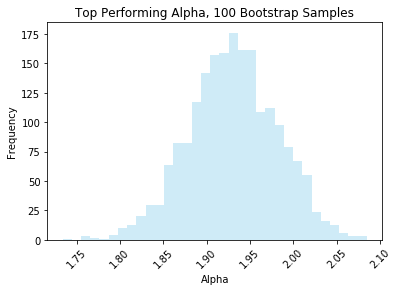

In [73]:
sns.distplot(top_alpha, color = 'skyblue', kde = False)
plt.xticks(rotation = 45)
plt.ylabel('Frequency')
plt.title('Top Performing Alpha, 100 Bootstrap Samples')

In [74]:
pd.DataFrame(df_results_sim['Alpha'].quantile([.025,.50,.975]))

,Alpha
0.025,1.828874
0.500,1.929954
0.975,2.024713
